In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler

In [3]:
trn = pd.read_csv('./splitfiles/z0/train.csv')
trn['flux_ratio_sq'] = np.power(trn['flux'] / trn['flux_err'], 2.0)
trn['flux_by_flux_ratio_sq'] = trn['flux'] * trn['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_trn = trn.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_trn.columns = new_columns
agg_trn['mjd_diff'] = agg_trn['mjd_max'] - agg_trn['mjd_min']
agg_trn['flux_diff'] = agg_trn['flux_max'] - agg_trn['flux_min']
agg_trn['flux_dif2'] = (agg_trn['flux_max'] - agg_trn['flux_min']) / agg_trn['flux_mean']
agg_trn['flux_w_mean'] = agg_trn['flux_by_flux_ratio_sq_sum'] / agg_trn['flux_ratio_sq_sum']
agg_trn['flux_dif3'] = (agg_trn['flux_max'] - agg_trn['flux_min']) / agg_trn['flux_w_mean']

del agg_trn['mjd_max'], agg_trn['mjd_min']
agg_trn.head()

del trn
gc.collect()

135

In [6]:
meta_trn = pd.read_csv('./splitfiles/z0/train_meta.csv')
meta_trn.head()

full_trn = agg_trn.reset_index().merge(
    right=meta_trn,
    how='outer',
    on='object_id'
)

if 'target' in full_trn:
    VAB = full_trn['target']
    del full_trn['target']
classes = sorted(VAB.unique())

class_weight = {
    c: 1 for c in classes
}

print('Unique classes : ', classes)

Unique classes :  [6, 16, 53, 65, 92]


In [7]:
if 'object_id' in full_trn:
    oof_df = full_trn[['object_id']]
    del full_trn['object_id'], full_trn['distmod'], full_trn['hostgal_specz']
    del full_trn['ra'], full_trn['decl'], full_trn['gal_l'],full_trn['gal_b'],full_trn['ddf']
    
    
trn_mean = full_trn.mean(axis=0)
full_trn.fillna(trn_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [8]:
full_trn_new = full_trn.copy()
ss = StandardScaler()
full_trn_ss = ss.fit_transform(full_trn_new)

/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [24]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [25]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 16, 53, 65, 92]
    class_weight = {6: 1, 16: 1, 53: 1, 65: 1, 92: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [26]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_trn_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [27]:
unique_VAB = np.unique(VAB)
class_map = dict()
for i,val in enumerate(unique_VAB):
    class_map[val] = i
        
y_map = np.zeros((VAB.shape[0],))
y_map = np.array([class_map[val] for val in VAB])
y_categorical = to_categorical(y_map)

In [28]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_VAB),))
for i in range(len(unique_VAB)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [29]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

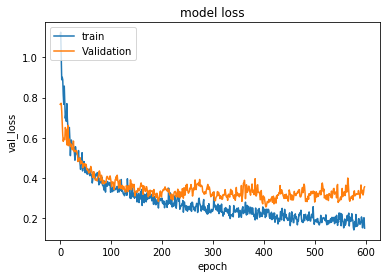

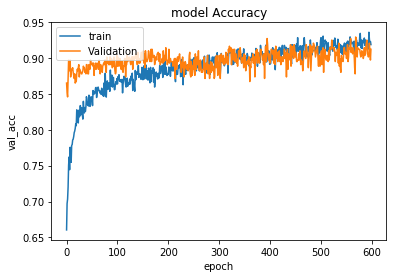

Loading Best Model
0.25405102709402805


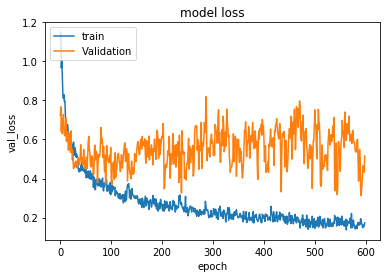

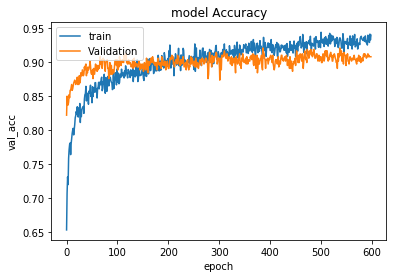

Loading Best Model
0.31363413015102765


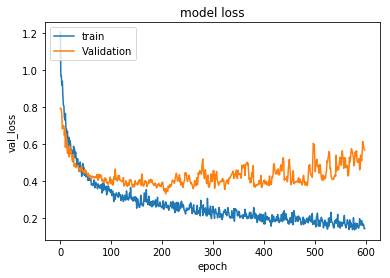

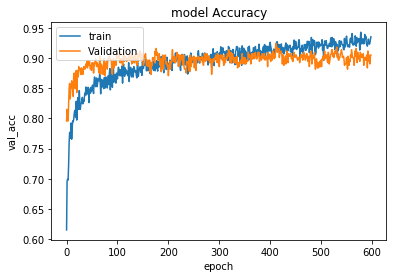

Loading Best Model
0.3312680318781746


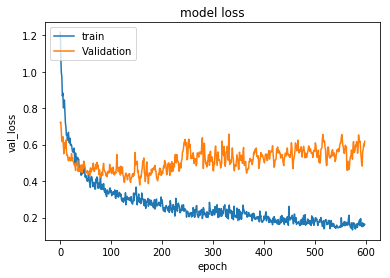

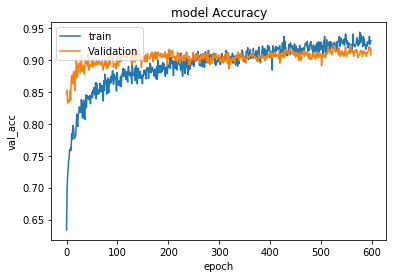

Loading Best Model
0.37978765877657217


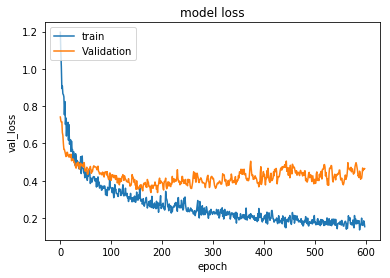

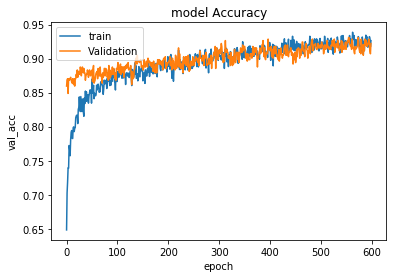

Loading Best Model
0.33686222668912785
MULTI WEIGHTED LOG LOSS : 0.32293 


In [30]:
clfs = []
oof_preds = np.zeros((len(full_trn_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_trn, y_trn = full_trn_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_trn_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_trn, y_trn,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [32]:
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [33]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = ['class 6', 'class 16', 'class 53', 'class 65', 'class 92']
del sample_sub;gc.collect()

5216

Normalized confusion matrix
[[0.75 0.05 0.03 0.1  0.07]
 [0.01 0.95 0.   0.01 0.03]
 [0.   0.   1.   0.   0.  ]
 [0.11 0.01 0.   0.87 0.01]
 [0.03 0.01 0.02 0.   0.95]]


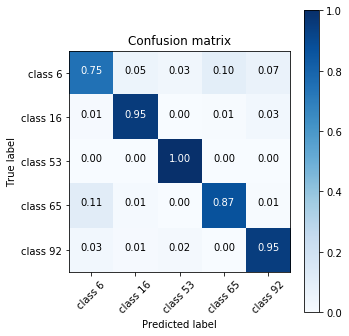

In [34]:
plt.figure(figsize=(5,5))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [18]:
meta_test = pd.read_csv('./splitfiles/z0/test_meta.csv')

import time

start = time.time()
chunks = 5000000
for i_c, df in enumerate(pd.read_csv('test_set.csv', chunksize=chunks, iterator=True)):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # Group by object id
    agg_test = df.groupby('object_id').agg(aggs)
    agg_test.columns = new_columns
    agg_test['mjd_diff'] = agg_test['mjd_max'] - agg_test['mjd_min']
    agg_test['flux_diff'] = agg_test['flux_max'] - agg_test['flux_min']
    agg_test['flux_dif2'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_mean']
    agg_test['flux_w_mean'] = agg_test['flux_by_flux_ratio_sq_sum'] / agg_test['flux_ratio_sq_sum']
    agg_test['flux_dif3'] = (agg_test['flux_max'] - agg_test['flux_min']) / agg_test['flux_w_mean']

    del agg_test['mjd_max'], agg_test['mjd_min']
#     del df
#     gc.collect()
    
    # Merge with meta data
    full_test = agg_test.reset_index().merge(
        right=meta_test,
        how='left',
        on='object_id'
    )
    full_test[full_trn.columns] = full_test[full_trn.columns].fillna(trn_mean)
    full_test_ss = ss.transform(full_test[full_trn.columns])
    # Make predictions
    preds = None
    for clf in clfs:
        if preds is None:
            preds = clf.predict_proba(full_test_ss) / folds.n_splits
        else:
            preds += clf.predict_proba(full_test_ss) / folds.n_splits
    
   # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds.shape[0])
    for i in range(preds.shape[1]):
        preds_99 *= (1 - preds[:, i])
    
    # Store predictions
    preds_df = pd.DataFrame(preds, columns=class_names)
    preds_df['object_id'] = full_test['object_id']
    preds_df['class_99'] = 0.14 * preds_99 / np.mean(preds_99) 
    
    if i_c == 0:
        preds_df.to_csv('prediction_z0.csv',  header=True, mode='a', index=False)
    else: 
        preds_df.to_csv('prediction_z0.csv',  header=False, mode='a', index=False)
        
    del agg_test, full_test, preds_df, preds
#     print('done')
    if (i_c + 1) % 10 == 0:
        print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60))

/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

       50000000 done in   8.7


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      100000000 done in  16.9


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      150000000 done in  26.5


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      200000000 done in  37.8


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      250000000 done in  52.1


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      300000000 done in  63.3


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      350000000 done in  71.6


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      400000000 done in  80.0


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by S

      450000000 done in  88.2


/home/astro/phrgvd/anaconda3/envs/Ma_Le/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [3]:
z = pd.read_csv('prediction_z0.csv')

print(z.groupby('object_id').size().max())
print((z.groupby('object_id').size() > 1).sum())

z = z.groupby('object_id').mean()

z.to_csv('single_predictions_z0.csv', index=True)

2
88


In [4]:
z.head()

,class 6,class 16,class 53,class 65,class 92,class_99
object_id,,,,,,
13,0.145282,0.009267,0.000175,0.845240,3.552360e-05,0.318500
14,0.000920,0.002727,0.000075,0.996232,4.541906e-05,0.009125
17,0.001256,0.002911,0.000047,0.995768,1.762309e-05,0.010243
23,0.009799,0.000848,0.000021,0.989331,9.690080e-07,0.025658
34,0.007971,0.000022,0.000079,0.991912,1.479902e-05,0.019501
